In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread
import cv2

from gen.load_data import load_data
from gen.datagen import balanced_generator_from_df


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')


In [4]:
train_df.head()

,image,id,label
0,../data/Train/CameraRGB/episode_0002_000287.png,episode_0002_000287,../data/Train/CameraSeg/episode_0002_000287.png
1,../data/Train/CameraRGB/episode_0008_000112.png,episode_0008_000112,../data/Train/CameraSeg/episode_0008_000112.png
2,../data/Train/CameraRGB/804.png,804,../data/Train/CameraSeg/804.png
3,../data/Train/CameraRGB/episode_0008_000286.png,episode_0008_000286,../data/Train/CameraSeg/episode_0008_000286.png
4,../data/Train/CameraRGB/episode_0003_000261.png,episode_0003_000261,../data/Train/CameraSeg/episode_0003_000261.png


In [5]:
valid_df.head()

,image,id,label
0,../data/Valid/CameraRGB/00019.png,00019,../data/Valid/CameraSeg/00019.png
1,../data/Valid/CameraRGB/00413.png,00413,../data/Valid/CameraSeg/00413.png
2,../data/Valid/CameraRGB/00035.png,00035,../data/Valid/CameraSeg/00035.png
3,../data/Valid/CameraRGB/00264.png,00264,../data/Valid/CameraSeg/00264.png
4,../data/Valid/CameraRGB/00172.png,00172,../data/Valid/CameraSeg/00172.png


In [6]:
test_df.head()

,image,id,label
0,../data/Test/CameraRGB/00019.png,00019,../data/Test/CameraSeg/00019.png
1,../data/Test/CameraRGB/00413.png,00413,../data/Test/CameraSeg/00413.png
2,../data/Test/CameraRGB/00035.png,00035,../data/Test/CameraSeg/00035.png
3,../data/Test/CameraRGB/00264.png,00264,../data/Test/CameraSeg/00264.png
4,../data/Test/CameraRGB/00172.png,00172,../data/Test/CameraSeg/00172.png


In [18]:
gen = balanced_generator_from_df(train_df, 12, (320, 416))

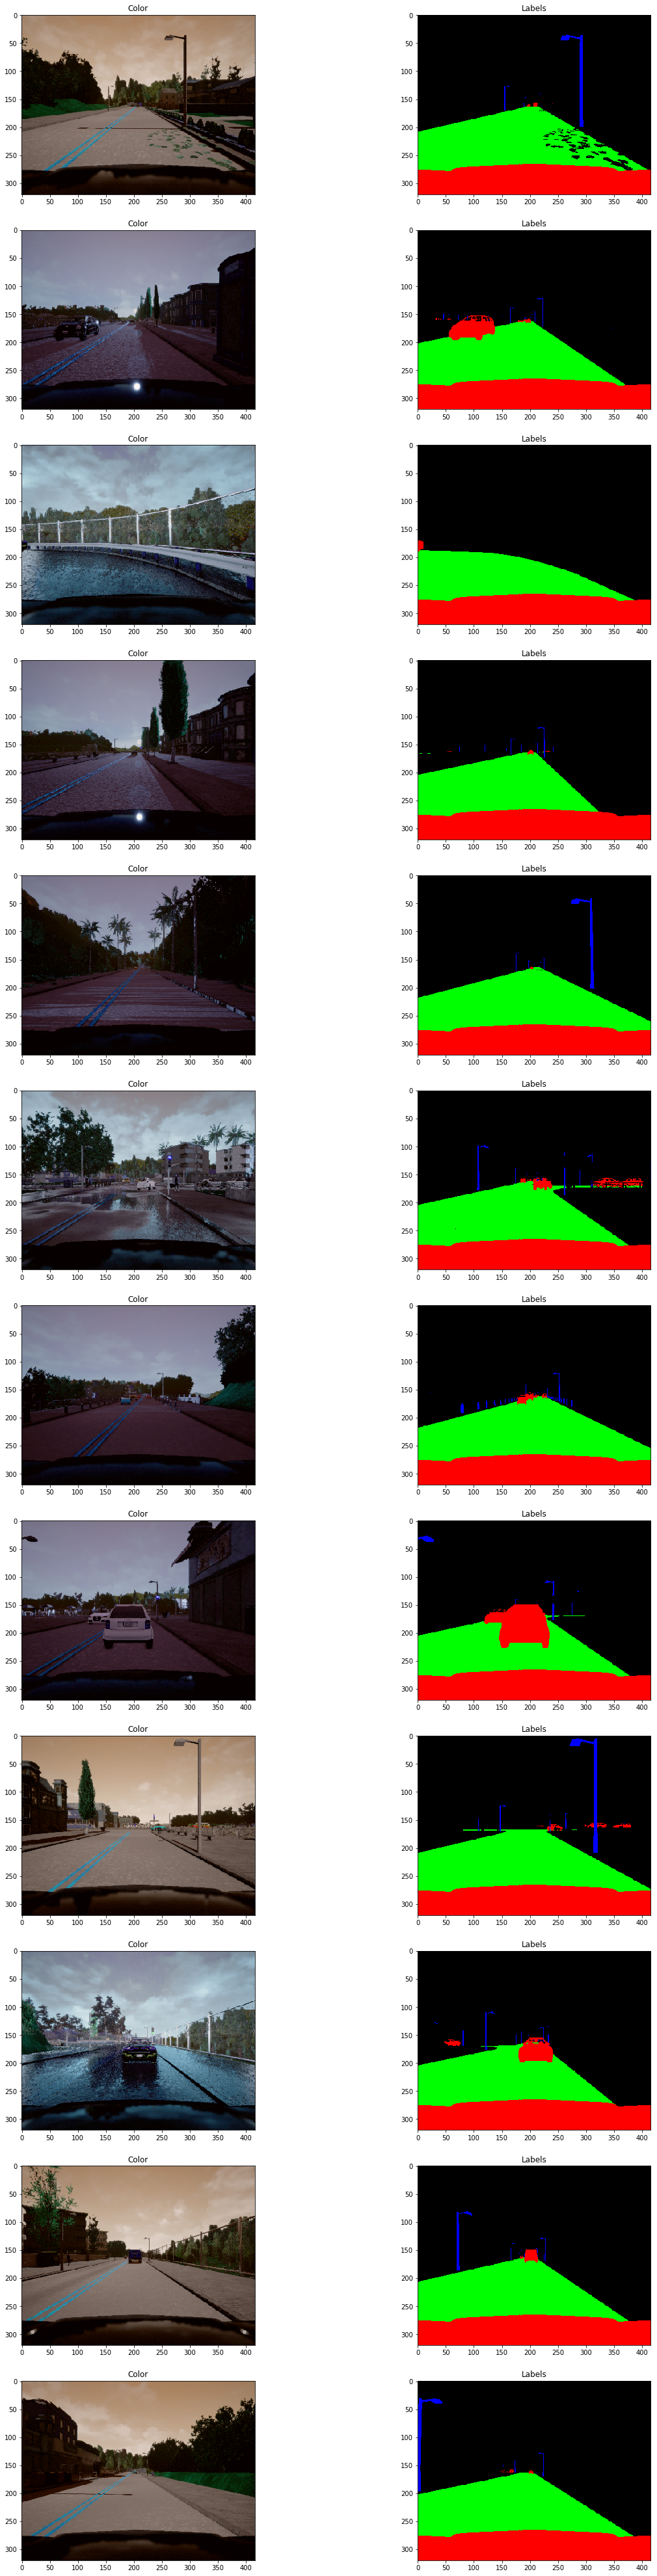

In [19]:
(rgb_batch, lab_batch) = next(gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    lab_img = np.clip(lab_img*255, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img[:, :, 0:3])
    ax2.set_title('Labels')

In [ ]:
from gen.generators import gen_func_patch, preprocess_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(**img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_label)

train_and_lab_gen = gen_func_patch(train_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(320, 416), batch_size = 32)


In [ ]:
from gen.generators import preprocess_label

bg, road, cars = 0, 0, 0
# for i, row in train_df.sample(2500).iterrows():
#     l = preprocess_label(imread(row['label']))
    
#     cars += l[:, :, 0].nonzero()[1].shape[0]
#     road += l[:, :, 1].nonzero()[1].shape[0]
#     bg   += l[:, :, 2].nonzero()[1].shape[0]

# print (bg, road, cars)


bg, road, cars = 0, 0, 0

for i in range(train_df.shape[0]//32):
    x, y = next(train_and_lab_gen)
    for l in y:
        cars += l[:, :, 0].nonzero()[1].shape[0]
        road += l[:, :, 1].nonzero()[1].shape[0]
        bg   += l[:, :, 2].nonzero()[1].shape[0]

In [ ]:
t = bg + road + cars
car_p = cars/t * 100.0
road_p = road/t * 100.0
bg_p = bg/t * 100.0

In [ ]:
print ("Car {}%, Road {}%, BG {}%".format(car_p, road_p, bg_p))

In [ ]:
1/car_p

In [ ]:
1/road_p

In [ ]:
1/bg_p

In [ ]:

from gen.generators import gen_func_patch, preprocess_label,  preprocess_multi_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function = preprocess_multi_label, **img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_multi_label)

train_and_lab_gen = gen_func_patch(train_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(320, 416), batch_size = 32)
# valid_and_lab_gen = gen_func(valid_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(480, 480), batch_size = 32)
# test_and_lab_gen = gen_func(test_df, rgb_gen2, lab_gen2, image_size=(600, 800),  target_size=(480, 480), batch_size = 32)

In [ ]:
(rgb_batch, lab_batch) = next(train_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(cv2.cvtColor(r_rgb_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')